In [140]:
import seaborn as sns
import pylab as rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib 
import pandas as pd 
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout,Bidirectional, GlobalAveragePooling1D,GRU,Flatten
from sklearn.preprocessing import MinMaxScaler
from  sklearn.model_selection import TimeSeriesSplit
from keras.callbacks import EarlyStopping
from tcn import TCN
from keras_self_attention import SeqSelfAttention
import tensorflow as tf
import math



In [141]:
df=pd.read_csv('/home/j/usfq/tesis/StockPredictionModels/Data/Complete.csv')
df

,Date,ticker_symbol,p_sentiment,Open,High,Low,Close,Volume,unrate,psr,m2,dspic,pce,reer,ir,ffer,tcs,indpro,ccpi
0,2015-01-02,AAPL,0.766185,27.847500,27.860001,26.837500,27.332500,212818400,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
1,2015-01-02,AMZN,0.506131,15.629000,15.737500,15.348000,15.426000,55664000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
2,2015-01-02,GOOG,0.846197,26.378078,26.490770,26.133251,26.168653,28951268,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
3,2015-01-02,GOOGL,0.819823,26.629999,26.790001,26.393999,26.477501,26480000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
4,2015-01-02,MSFT,0.795557,46.660000,47.419998,46.540001,46.759998,27913900,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7539,2019-12-31,AMZN,0.715115,92.099998,92.663002,91.611504,92.391998,50130000,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7540,2019-12-31,GOOG,0.656211,66.505501,66.900002,66.454247,66.850998,19236000,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7541,2019-12-31,GOOGL,0.777357,66.789497,67.032997,66.606499,66.969498,19514000,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7542,2019-12-31,MSFT,0.683018,156.770004,157.770004,156.449997,157.699997,18369400,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651


In [142]:
#turn date into unix time
#df['Date'] = pd.to_datetime(df['Date'])
#df['Date'] = df['Date'].apply(lambda x: x.timestamp())
#df

In [143]:
#generate new dataframes for each ticker_symbol
df_dict={}
for key in df['ticker_symbol'].unique():
    df_dict[key]=df[df['ticker_symbol']==key]
    df_dict[key]=df_dict[key].drop(columns=['ticker_symbol'])
    df_dict[key]=df_dict[key].sort_values(by=['Date']).reset_index(drop=True)
    #df_dict[key]=df_dict[key].drop(columns=['Date'])
    print(key,df_dict[key].shape)
    print(df_dict[key].head(-1))

AAPL (1254, 18)
            Date  p_sentiment       Open       High        Low      Close  \
0     2015-01-02     0.766185  27.847500  27.860001  26.837500  27.332500   
1     2015-01-05     0.846650  27.072500  27.162500  26.352501  26.562500   
2     2015-01-06     0.712894  26.635000  26.857500  26.157499  26.565001   
3     2015-01-07     0.744531  26.799999  27.049999  26.674999  26.937500   
4     2015-01-08     0.769826  27.307501  28.037500  27.174999  27.972500   
...          ...          ...        ...        ...        ...        ...   
1248  2019-12-23     0.761074  70.132500  71.062500  70.092499  71.000000   
1249  2019-12-24     0.775495  71.172501  71.222504  70.730003  71.067497   
1250  2019-12-26     0.742264  71.205002  72.495003  71.175003  72.477501   
1251  2019-12-27     0.768797  72.779999  73.492500  72.029999  72.449997   
1252  2019-12-30     0.746877  72.364998  73.172501  71.305000  72.879997   

         Volume  unrate  psr       m2    dspic      pce    

In [144]:
ticker='TSLA'

In [145]:
df=df_dict[ticker].copy()
df.head()

,Date,p_sentiment,Open,High,Low,Close,Volume,unrate,psr,m2,dspic,pce,reer,ir,ffer,tcs,indpro,ccpi
0,2015-01-02,0.710122,14.858000,14.883333,14.217333,14.620667,71466000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
1,2015-01-05,0.728551,14.303333,14.433333,13.810667,14.006000,80527500,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
2,2015-01-06,0.658187,14.004000,14.280000,13.614000,14.085333,93928500,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
3,2015-01-07,0.646626,14.223333,14.318667,13.985333,14.063333,44526000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
4,2015-01-08,0.696584,14.187333,14.253333,14.000667,14.041333,51637500,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811


In [146]:
#putting the close column on the last position
df=df[['Date', 'p_sentiment', 'Open', 'High', 'Low',
       'Volume', 'unrate', 'psr', 'm2', 'dspic', 'pce', 'reer', 'ir', 'ffer',
       'tcs', 'indpro', 'ccpi', 'Close']]

In [147]:
dates = pd.to_datetime(df['Date'])

In [148]:
cols=list(df)[1:]
cols

['p_sentiment',
 'Open',
 'High',
 'Low',
 'Volume',
 'unrate',
 'psr',
 'm2',
 'dspic',
 'pce',
 'reer',
 'ir',
 'ffer',
 'tcs',
 'indpro',
 'ccpi',
 'Close']

In [149]:
df_for_training = df[cols].astype(float)

In [150]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_for_training)

In [151]:
print(scaled_data)

[[0.73349331 0.27521525 0.24356139 ... 0.77924797 0.         0.26330631]
 [0.77183473 0.24678828 0.21948349 ... 0.77924797 0.         0.23121105]
 [0.62544497 0.23144731 0.21127918 ... 0.77924797 0.         0.23535347]
 ...
 [0.50389745 1.         1.         ... 0.57323507 1.         0.99805053]
 [0.30306162 0.97878229 0.97749165 ... 0.57323507 1.         0.9434678 ]
 [0.28882563 0.89749897 0.94998933 ... 0.57323507 1.         0.95610395]]


In [152]:
#split scaled data into training, val and testing
#train_data=scaled_data[0:1000,:]
#val_data=scaled_data[1000:1125,:]
#test_data=scaled_data[1125:,:]

In [153]:
n_future = 1 # Number of days we want to predict into the future
n_past = 14 # Number of past days we want to use to predict the future

In [154]:
X=[]
y=[]
for i in range(n_past, len(scaled_data) - n_future +1):
    X.append(scaled_data[i - n_past:i, 0:df_for_training.shape[1]])
    y.append(scaled_data[i + n_future - 1:i + n_future, len(cols)-1])

In [155]:
#shape of X_s and y_s
X, y = np.array(X), np.array(y)
print(X.shape)
print(y.shape)

(1244, 14, 17)
(1244, 1)


In [156]:
import math as m
def n_layers(ks):
    n=m.ceil(m.log2((((n_past-1)*(2-1))/(ks-1))+1))
    return n

In [157]:
def build_model(input_shape, output_shape):
    ks=7
    model=Sequential()
    model.add(
        Bidirectional(
            TCN(
                input_shape=input_shape,
                kernel_size=ks,
                return_sequences=True,
                dilations=[2**i for i in range(0,n_layers(ks))],
                activation='relu',
                nb_filters=17,
                padding='causal',
                #dropout_rate=0.25,
                kernel_initializer='he_normal',
                use_skip_connections=True
            )   
        )
    )
    model.add(GlobalAveragePooling1D())
    model.add(Dense(output_shape))
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-4),loss='mse')
    return model

early_stop=EarlyStopping(monitor='val_loss',patience=10)

Epoch 1/1000


4/4 [==============================] - 2s 102ms/step - loss: 0.1013 - val_loss: 0.1777
Epoch 2/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.0550 - val_loss: 0.1113
Epoch 3/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.0250 - val_loss: 0.0634
Epoch 4/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.0091 - val_loss: 0.0326
Epoch 5/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.0042 - val_loss: 0.0154
Epoch 6/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.0057 - val_loss: 0.0074
Epoch 7/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.0088 - val_loss: 0.0044
Epoch 8/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.0104 - val_loss: 0.0039
Epoch 9/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.0099 - val_loss: 0.0048
Epoch 10/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.0080 - val_loss: 0.0068
Epoch 11/1000
4/4 [==

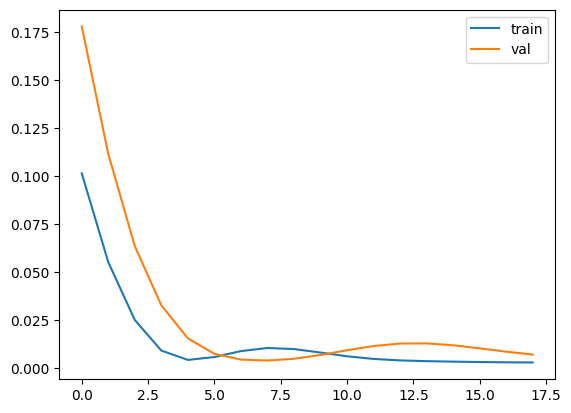

4/4 [==============================] - 0s 27ms/step
mae: 0.8908794929658332


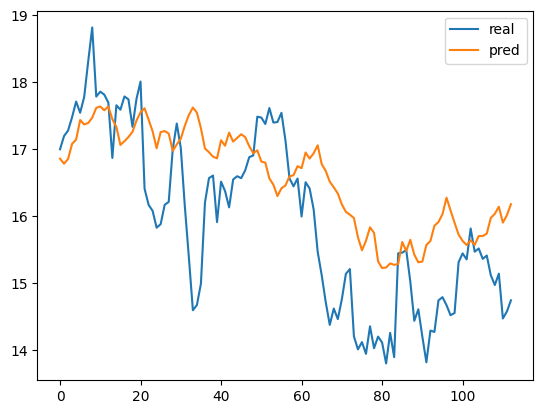

Epoch 1/1000
7/7 [==============================] - 2s 60ms/step - loss: 0.0184 - val_loss: 8.7543e-04
Epoch 2/1000
7/7 [==============================] - 0s 8ms/step - loss: 0.0042 - val_loss: 0.0072
Epoch 3/1000
7/7 [==============================] - 0s 8ms/step - loss: 0.0035 - val_loss: 0.0092
Epoch 4/1000
7/7 [==============================] - 0s 7ms/step - loss: 0.0029 - val_loss: 0.0052
Epoch 5/1000
7/7 [==============================] - 0s 7ms/step - loss: 0.0021 - val_loss: 0.0024
Epoch 6/1000
7/7 [==============================] - 0s 8ms/step - loss: 0.0023 - val_loss: 0.0017
Epoch 7/1000
7/7 [==============================] - 0s 8ms/step - loss: 0.0023 - val_loss: 0.0020
Epoch 8/1000
7/7 [==============================] - 0s 8ms/step - loss: 0.0021 - val_loss: 0.0024
Epoch 9/1000
7/7 [==============================] - 0s 8ms/step - loss: 0.0019 - val_loss: 0.0023
Epoch 10/1000
7/7 [==============================] - 0s 8ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 11/1000


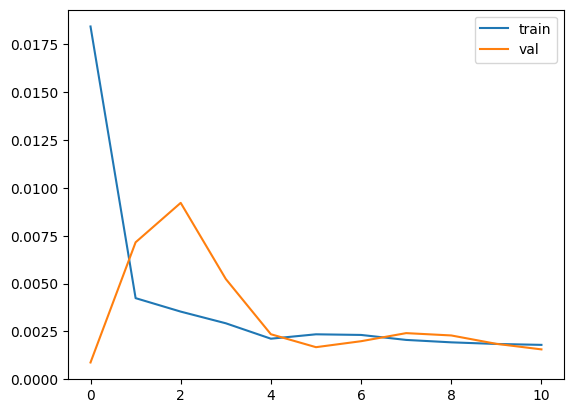

4/4 [==============================] - 0s 3ms/step
mae: 1.5419440817935912


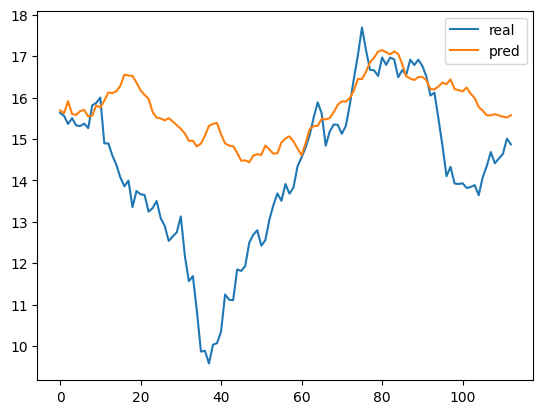

Epoch 1/1000
10/10 [==============================] - 2s 63ms/step - loss: 0.2152 - val_loss: 0.4454
Epoch 2/1000
10/10 [==============================] - 0s 7ms/step - loss: 0.0893 - val_loss: 0.2555
Epoch 3/1000
10/10 [==============================] - 0s 7ms/step - loss: 0.0397 - val_loss: 0.1499
Epoch 4/1000
10/10 [==============================] - 0s 7ms/step - loss: 0.0300 - val_loss: 0.1038
Epoch 5/1000
10/10 [==============================] - 0s 6ms/step - loss: 0.0305 - val_loss: 0.0899
Epoch 6/1000
10/10 [==============================] - 0s 6ms/step - loss: 0.0296 - val_loss: 0.0901
Epoch 7/1000
10/10 [==============================] - 0s 8ms/step - loss: 0.0274 - val_loss: 0.0933
Epoch 8/1000
10/10 [==============================] - 0s 7ms/step - loss: 0.0254 - val_loss: 0.0943
Epoch 9/1000
10/10 [==============================] - 0s 7ms/step - loss: 0.0239 - val_loss: 0.0920
Epoch 10/1000
10/10 [==============================] - 0s 7ms/step - loss: 0.0225 - val_loss: 0.087

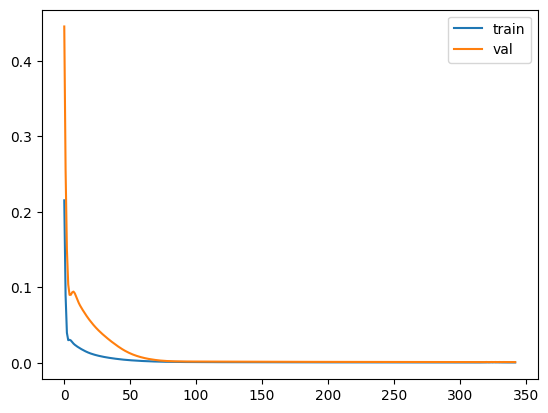

4/4 [==============================] - 0s 3ms/step
mae: 1.2332814651116566


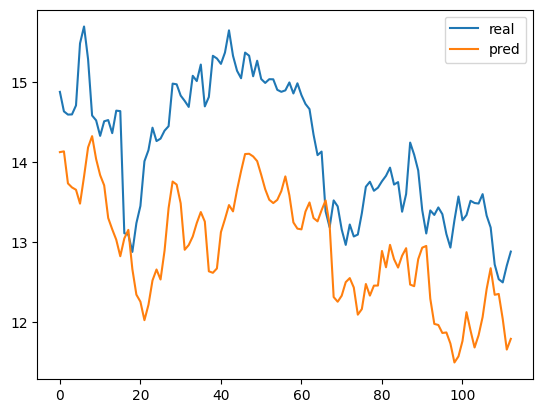

Epoch 1/1000
13/13 [==============================] - 2s 45ms/step - loss: 0.0159 - val_loss: 0.0025
Epoch 2/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.0088 - val_loss: 0.0020
Epoch 3/1000
13/13 [==============================] - 0s 8ms/step - loss: 0.0077 - val_loss: 0.0019
Epoch 4/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.0061 - val_loss: 0.0017
Epoch 5/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.0057 - val_loss: 0.0021
Epoch 6/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.0054 - val_loss: 0.0021
Epoch 7/1000
13/13 [==============================] - 0s 7ms/step - loss: 0.0052 - val_loss: 0.0022
Epoch 8/1000
13/13 [==============================] - 0s 7ms/step - loss: 0.0050 - val_loss: 0.0024
Epoch 9/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.0048 - val_loss: 0.0023
Epoch 10/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.0047 - val_loss: 0.002

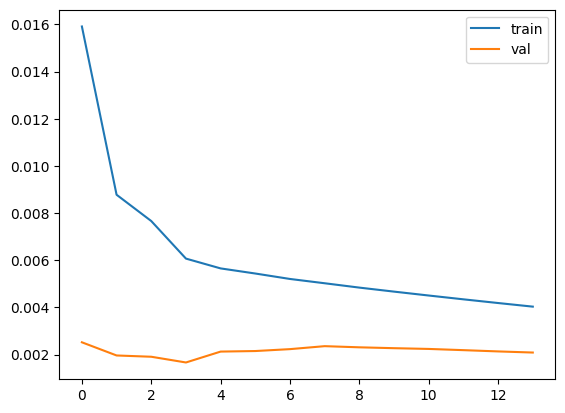

4/4 [==============================] - 0s 3ms/step
mae: 1.5245139217723747


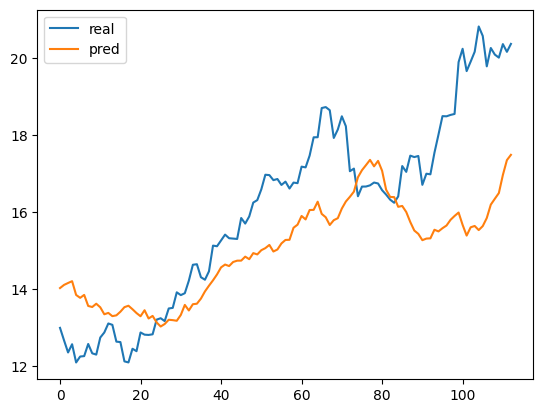

Epoch 1/1000
16/16 [==============================] - 2s 34ms/step - loss: 0.0653 - val_loss: 0.0517
Epoch 2/1000
16/16 [==============================] - 0s 7ms/step - loss: 0.0213 - val_loss: 0.0072
Epoch 3/1000
16/16 [==============================] - 0s 7ms/step - loss: 0.0132 - val_loss: 0.0101
Epoch 4/1000
16/16 [==============================] - 0s 6ms/step - loss: 0.0099 - val_loss: 0.0184
Epoch 5/1000
16/16 [==============================] - 0s 7ms/step - loss: 0.0088 - val_loss: 0.0189
Epoch 6/1000
16/16 [==============================] - 0s 6ms/step - loss: 0.0075 - val_loss: 0.0172
Epoch 7/1000
16/16 [==============================] - 0s 6ms/step - loss: 0.0065 - val_loss: 0.0171
Epoch 8/1000
16/16 [==============================] - 0s 7ms/step - loss: 0.0058 - val_loss: 0.0166
Epoch 9/1000
16/16 [==============================] - 0s 7ms/step - loss: 0.0052 - val_loss: 0.0154
Epoch 10/1000
16/16 [==============================] - 0s 6ms/step - loss: 0.0047 - val_loss: 0.014

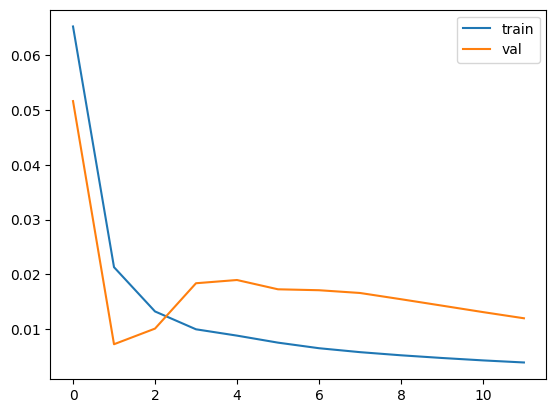

4/4 [==============================] - 0s 2ms/step
mae: 4.507344848738678


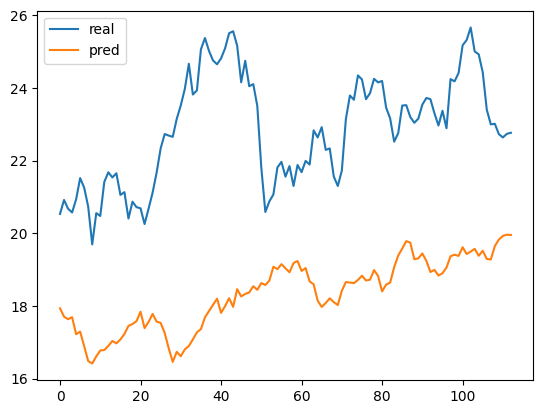

Epoch 1/1000
20/20 [==============================] - 2s 28ms/step - loss: 0.0525 - val_loss: 0.1503
Epoch 2/1000
20/20 [==============================] - 0s 7ms/step - loss: 0.0176 - val_loss: 0.0474
Epoch 3/1000
20/20 [==============================] - 0s 7ms/step - loss: 0.0169 - val_loss: 0.0414
Epoch 4/1000
20/20 [==============================] - 0s 6ms/step - loss: 0.0101 - val_loss: 0.0268
Epoch 5/1000
20/20 [==============================] - 0s 6ms/step - loss: 0.0075 - val_loss: 0.0141
Epoch 6/1000
20/20 [==============================] - 0s 6ms/step - loss: 0.0061 - val_loss: 0.0086
Epoch 7/1000
20/20 [==============================] - 0s 7ms/step - loss: 0.0050 - val_loss: 0.0060
Epoch 8/1000
20/20 [==============================] - 0s 6ms/step - loss: 0.0044 - val_loss: 0.0051
Epoch 9/1000
20/20 [==============================] - 0s 6ms/step - loss: 0.0039 - val_loss: 0.0051
Epoch 10/1000
20/20 [==============================] - 0s 7ms/step - loss: 0.0036 - val_loss: 0.005

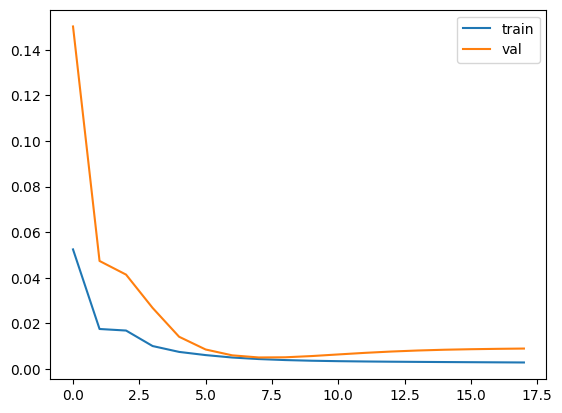

4/4 [==============================] - 0s 3ms/step
mae: 1.9245889436262014


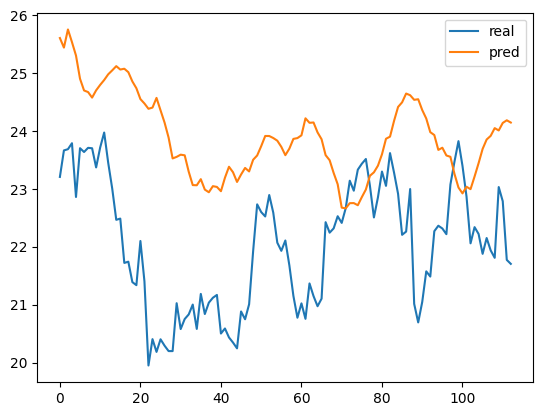

Epoch 1/1000
23/23 [==============================] - 2s 26ms/step - loss: 0.0118 - val_loss: 0.0210
Epoch 2/1000
23/23 [==============================] - 0s 6ms/step - loss: 0.0110 - val_loss: 0.0056
Epoch 3/1000
23/23 [==============================] - 0s 5ms/step - loss: 0.0055 - val_loss: 0.0053
Epoch 4/1000
23/23 [==============================] - 0s 6ms/step - loss: 0.0040 - val_loss: 0.0057
Epoch 5/1000
23/23 [==============================] - 0s 5ms/step - loss: 0.0037 - val_loss: 0.0049
Epoch 6/1000
23/23 [==============================] - 0s 5ms/step - loss: 0.0034 - val_loss: 0.0046
Epoch 7/1000
23/23 [==============================] - 0s 5ms/step - loss: 0.0032 - val_loss: 0.0044
Epoch 8/1000
23/23 [==============================] - 0s 5ms/step - loss: 0.0031 - val_loss: 0.0042
Epoch 9/1000
23/23 [==============================] - 0s 5ms/step - loss: 0.0029 - val_loss: 0.0040
Epoch 10/1000
23/23 [==============================] - 0s 6ms/step - loss: 0.0028 - val_loss: 0.003

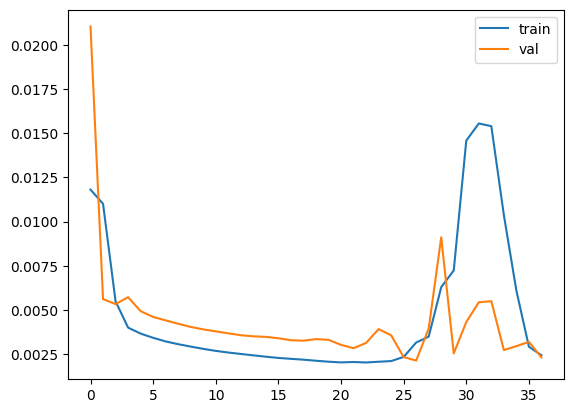

4/4 [==============================] - 0s 3ms/step
mae: 1.893390457666448


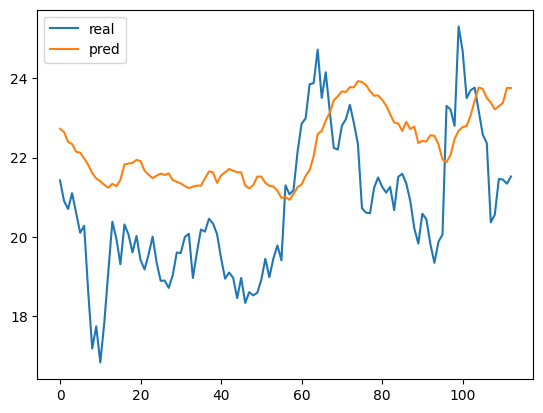

Epoch 1/1000
26/26 [==============================] - 2s 24ms/step - loss: 0.2735 - val_loss: 0.0618
Epoch 2/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.0338 - val_loss: 0.0581
Epoch 3/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.0370 - val_loss: 0.0518
Epoch 4/1000
26/26 [==============================] - 0s 6ms/step - loss: 0.0213 - val_loss: 0.0588
Epoch 5/1000
26/26 [==============================] - 0s 5ms/step - loss: 0.0141 - val_loss: 0.0710
Epoch 6/1000
26/26 [==============================] - 0s 6ms/step - loss: 0.0111 - val_loss: 0.0692
Epoch 7/1000
26/26 [==============================] - 0s 6ms/step - loss: 0.0093 - val_loss: 0.0631
Epoch 8/1000
26/26 [==============================] - 0s 6ms/step - loss: 0.0082 - val_loss: 0.0550
Epoch 9/1000
26/26 [==============================] - 0s 6ms/step - loss: 0.0074 - val_loss: 0.0469
Epoch 10/1000
26/26 [==============================] - 0s 6ms/step - loss: 0.0068 - val_loss: 0.039

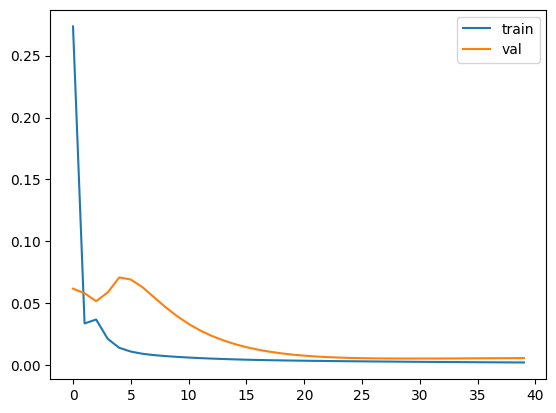

4/4 [==============================] - 0s 3ms/step
mae: 1.5421074781342903


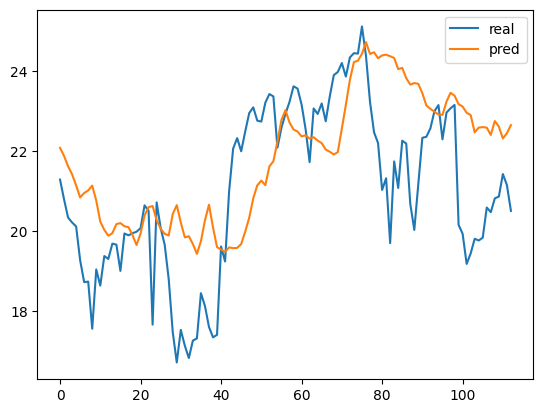

Epoch 1/1000
29/29 [==============================] - 2s 25ms/step - loss: 0.0469 - val_loss: 0.0269
Epoch 2/1000
29/29 [==============================] - 0s 5ms/step - loss: 0.0262 - val_loss: 0.0368
Epoch 3/1000
29/29 [==============================] - 0s 6ms/step - loss: 0.0159 - val_loss: 0.0239
Epoch 4/1000
29/29 [==============================] - 0s 5ms/step - loss: 0.0105 - val_loss: 0.0167
Epoch 5/1000
29/29 [==============================] - 0s 6ms/step - loss: 0.0077 - val_loss: 0.0112
Epoch 6/1000
29/29 [==============================] - 0s 6ms/step - loss: 0.0059 - val_loss: 0.0088
Epoch 7/1000
29/29 [==============================] - 0s 6ms/step - loss: 0.0049 - val_loss: 0.0081
Epoch 8/1000
29/29 [==============================] - 0s 5ms/step - loss: 0.0043 - val_loss: 0.0081
Epoch 9/1000
29/29 [==============================] - 0s 5ms/step - loss: 0.0039 - val_loss: 0.0082
Epoch 10/1000
29/29 [==============================] - 0s 6ms/step - loss: 0.0036 - val_loss: 0.008

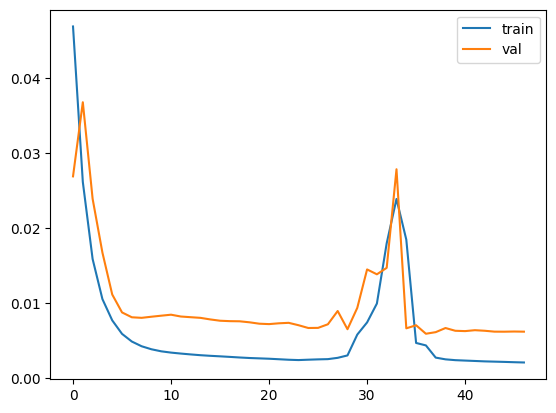

4/4 [==============================] - 0s 3ms/step
mae: 1.2846650324842062


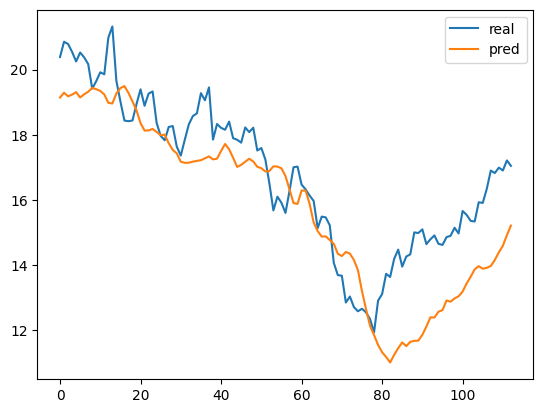

Epoch 1/1000
32/32 [==============================] - 2s 23ms/step - loss: 0.0328 - val_loss: 0.0179
Epoch 2/1000
32/32 [==============================] - 0s 6ms/step - loss: 0.0107 - val_loss: 0.0125
Epoch 3/1000
32/32 [==============================] - 0s 5ms/step - loss: 0.0085 - val_loss: 0.0138
Epoch 4/1000
32/32 [==============================] - 0s 5ms/step - loss: 0.0067 - val_loss: 0.0086
Epoch 5/1000
32/32 [==============================] - 0s 5ms/step - loss: 0.0054 - val_loss: 0.0060
Epoch 6/1000
32/32 [==============================] - 0s 5ms/step - loss: 0.0050 - val_loss: 0.0056
Epoch 7/1000
32/32 [==============================] - 0s 5ms/step - loss: 0.0045 - val_loss: 0.0060
Epoch 8/1000
32/32 [==============================] - 0s 5ms/step - loss: 0.0041 - val_loss: 0.0057
Epoch 9/1000
32/32 [==============================] - 0s 6ms/step - loss: 0.0038 - val_loss: 0.0049
Epoch 10/1000
32/32 [==============================] - 0s 5ms/step - loss: 0.0036 - val_loss: 0.004

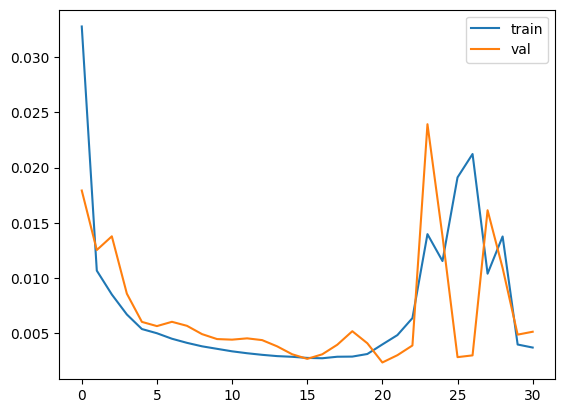

4/4 [==============================] - 0s 3ms/step
mae: 1.6666525366772678


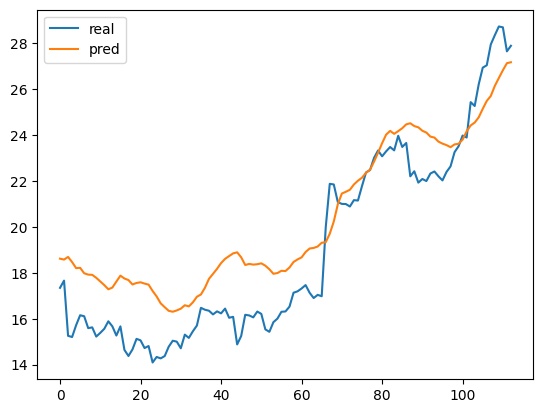

In [158]:
tscv = TimeSeriesSplit(n_splits=10)
maes=[]
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test= y[train_index], y[test_index]
    val_split = int(len(train_index) * 0.9)  # Adjust the validation split percentage as needed
    X_train, x_val = X_train[:val_split], X_train[val_split:]
    y_train, y_val = y_train[:val_split], y_train[val_split:]

    model=build_model(input_shape=(X_train.shape[1],X_train.shape[2]),output_shape=y_train.shape[1])
    history=model.fit(X_train,y_train,epochs=1000,validation_data=(x_val,y_val),shuffle=False, callbacks=[early_stop])
    plt.plot(history.history['loss'],label='train')
    plt.plot(history.history['val_loss'],label='val')
    plt.legend()
    plt.show()

    y_test=np.repeat(y_test,X.shape[2],axis=1)
    y_test=scaler.inverse_transform(y_test)[:,-1] 

    y_pred=model.predict(X_test)
    pred=np.repeat(y_pred,X_train.shape[2],axis=1)
    pred=scaler.inverse_transform(pred)[:,-1]
    
    mae=np.mean(np.abs(pred-y_test))
    maes.append(mae)
    print('mae:',mae)

    #plotting the results
    plt.plot(y_test, label='real')
    plt.plot(pred, label='pred') 
    plt.legend()
    plt.show()



In [159]:
model.summary()

Model: "sequential_63"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_63 (Bidirect  (None, 14, 34)            16320     
 ional)                                                          
                                                                 
 global_average_pooling1d_6  (None, 34)                0         
 3 (GlobalAveragePooling1D)                                      
                                                                 
 dense_63 (Dense)            (None, 1)                 35        
                                                                 
Total params: 16355 (63.89 KB)
Trainable params: 16355 (63.89 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [160]:
avg_mae=np.mean(maes)
print('Average mae:',avg_mae)

Average mae: 1.8009368258970546
